In [1]:
import numpy as np
import matplotlib.pyplot as plt
from util.logger import EventTracker
from util.basis_scaled import *
from util.plot_tools import *
from boundary_solvers.gauss_grid_2d import StokesDirichletProblem
from scipy.io import loadmat
import matplotlib.pyplot as plt
from util.interp import PiecewiseInterp2D
from hmm.stokes import *
from itertools import product
from hmm.stokes_deep import DeepMicroSolver, get_net
import matplotlib
import torch.nn as nn

#matplotlib.rcParams['text.usetex'] = True
#pretty_pyplot_layout()

np.random.seed(0)
net_dir = "/mnt/data0/emastr/article_training_nodecay/"
MESH_PATH = "/home/emastr/deep-micro-slip-model/data/mesh/"
figures_dir = "/home/emastr/deep-micro-slip-model/data/figures/"
simulation_dir = "/home/emastr/deep-micro-slip-model/data/stokes_fenics/"
run_dir = "/home/emastr/deep-micro-slip-model/data/reference_2/"

#save_dir = "/home/emastr/deep-micro-slip-model/data/hmm_coupling_error/"
save_dir = "/mnt/data0/emastr/hmm_coupling_v2/"
deep_save_dir = "/mnt/data0/emastr/hmm_coupling_deep/"

In [2]:
from dataclasses import dataclass
from multiprocessing import Pool

@dataclass
class HyperParams:
    nMic: int
    xDim: int
    yDim: int
    width: float
    height: float
    tol: float
    max_iter: int
    num_pts: int
    
    
class Setup():
    def __init__(self, data: StokesData, param: HyperParams):#, net: nn.Module, net_settings: dict):
        """Create a new HMM setup with the given parameters."""
        self.params = param
        self.data = data
        
        # Macro problem
        macro = StokesMacProb(data, lambda x,a: fft_interp(x, a, dom=data.dom[0]))
        macro_solver = MacroSolver(param.xDim, param.yDim, tol=param.tol)
        
        # Micro problems
        self.xPos = np.linspace(data.dom[0][0], data.dom[0][1], param.nMic+1)[1:] - param.width/2 - (data.dom[0][1]-data.dom[0][0]) / param.nMic/1
        micros = [StokesTrapezMicProb(data, x, param.width, param.height, 0.0, 8, param.xDim, param.yDim, num_pts=param.num_pts) for x in self.xPos]
        micro_solvers = [MicroSolver(m, tol=param.tol) for m in micros]
        #deep_micro_solvers = [DeepMicroSolver(m, net, net_settings, tol=param.tol) for m in micros]
        
        # Convergence checker
        conv_checker = ConvergenceChecker(macro, micros, tol=param.tol)
        
        # HMM problem
        self.hmm_problem = StokesHMMProblem(macro, micros, data, convergence_checker=conv_checker)
        self.hmm_solver = IterativeHMMSolver(macro_solver, micro_solvers)
        #self.hmm_deep_solver = IterativeHMMSolver(macro_solver, deep_micro_solvers)
        
        
    def solve(self, **kwargs):
        macro_guess = self.hmm_solver.macro_solver.solve(self.hmm_problem.macro)
        (macro_sol, micro_sols) = self.hmm_solver.solve(self.hmm_problem, macro_guess=macro_guess, verbose=True, maxiter=self.params.max_iter, tol=self.params.tol)
        #(deep_macro_sol, deep_micro_sols) = self.hmm_deep_solver.solve(self.hmm_problem, macro_guess=macro_guess, verbose=True, maxiter=self.params.max_iter, tol=self.params.tol)
        
        return micro_sols, macro_sol, macro_guess #deep_micro_sols, deep_macro_sol, macro_guess
    
    
    def save_sol(self, macro_sol, filename):
        data = self.params.__dict__
        data['mic_sol'] = [m.avg_vec for m in self.hmm_solver.micro_solvers]
        data['sol_u'] = macro_sol.u.eval_grid()
        data['sol_v'] = macro_sol.v.eval_grid()
        #data['deep_sol_u'] = deep_macro_sol.u.eval_grid()
        #data['deep_sol_v'] = deep_macro_sol.v.eval_grid()
        #print(np.linalg.norm(data['sol_u'] - data['deep_sol_u'])/np.linalg.norm(data['sol_u']))
        np.save(filename, data)
        
    @staticmethod
    def load_sol(filename):
        data = np.load(filename, allow_pickle=True).flatten()[0]
        u = data.pop('sol_u')
        v = data.pop('sol_v')
        m = data.pop('mic_sol')
        #u_deep = data.pop('deep_sol_u')
        #v_deep = data.pop('deep_sol_v')
        par = HyperParams(**data)
        return par, u, v, m#, u_deep, v_deep

In [3]:
from multiprocessing import Pool
#step = [1]#[1, 2, 3, 4, 6, 8, 11, 16, 22, 32, 46, 64]#, 128]
step = [1, 2, 3, 4, 6, 8, 11, 16, 22, 32, 46, 64]#, 128]
#M_list = [256]#[s * 20 for s in step]
M_list = [s * 20 for s in step]
#i_list = list(range(2,80,8))#:list(range(50,60,1))
i_list = [2, 42-16, 42, 42+16]#


for i in i_list:
    
    def run(m):
        with open(f"/home/emastr/deep-micro-slip-model/data/logs/classical.log", "a") as f:
            f.write(f"START --- Running sim {i} with {m} discretisation points \n")
        data, info = StokesData.load_from_matlab(f"{run_dir}run_{i}.mat")
        data_big_domain = data
        dom = data.dom
        eps = info["eps"]
        n = 7
        w = 5

        params = HyperParams(nMic=n, xDim=21, yDim=21, width=w*eps, height=w*eps*0.8, tol=1e-8, max_iter=30, num_pts=m)
        setup = Setup(data, params)
        micro_sols, macro_sol, macro_guess = setup.solve()
        setup.save_sol(macro_sol, f"{save_dir}big_run_{i}_{m}_sol.npy")
                
        with open(f"/home/emastr/deep-micro-slip-model/data/logs/classical.log", "a") as f:
            f.write(f"----- END Running sim {i} with {m} discretisation points \n")
    
    p = Pool(16)
    p.map(run, M_list)
#    for m in M_list:
#        print(f"Solving sim {i} with {m} discretisation points")
#        data, info = StokesData.load_from_matlab(f"{run_dir}run_{i}.mat")
#        data_big_domain = data
#        dom = data.dom
#        eps = info["eps"]
#        n = 7
#        w = 5#
#
#        params = HyperParams(nMic=n, xDim=21, yDim=21, width=w*eps, height=w*eps*0.8, tol=1e-8, max_iter=30, num_pts=m)
#        setup = Setup(data, params)
#        micro_sols, macro_sol, macro_guess = setup.solve()#
#
#        problem = StokesTrapezMicProb(data, 0.0, params.width, params.height, 0.0, 8, params.xDim, params.yDim, num_pts=m)
#        solver = MicroSolver(problem, tol=1e-10)
#        setup.save_sol(macro_sol, f"{save_dir}big_run_{i}_{m}_sol.npy")

In [ ]:
step = [1, 2, 4, 8, 16, 32, 64]
M_list = [s * 16 for s in step]
i_list = [2, 42, 74]

for i in i_list:
    param_true, u_true, v_true, micsol_true = Setup.load_sol(f"{save_dir}big_run_{i}_{M_list[-1]}_sol.npy")
    coupling_error = []
    micro_error = []
    data, info = StokesData.load_from_matlab(f"{run_dir}run_{i}.mat")
    for s, m in zip(step[:-1], M_list[:-1]):
        param, u, v, micsol = Setup.load_sol(f"{save_dir}run_{i}_{m}_sol.npy")
        #print(f"Error for sim {i} with {m} discretisation points")
        (N, M) = u.shape
        eps = info["eps"]
        
        
        micro_error.append(np.linalg.norm(micsol[0][::s] - micsol_true[0][::step[-1]])/np.linalg.norm(micsol_true[0][::step[-1]]))
        coupling_error.append(np.linalg.norm(u - u_true)/np.linalg.norm(u_true))
    #plt.plot(M_list[:-1], coupling_error, label=f"$epsilon = {eps:.0e}$")
    plt.plot(micro_error, coupling_error, label=f"$epsilon = {eps:.0e}$")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Normalized error in micro solution")
plt.ylabel("Normalized error in HMM solution")

plt.figure()
plt.imshow(u)
        
    


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data0/emastr/hmm_coupling/run_2_1024_sol.npy'

In [ ]:
#print(info)
for i in range(2,80,8):
    data, info = StokesData.load_from_matlab(f"{run_dir}run_{i}.mat")
    print(f"{i}, f={info["freq_g"]}, e={info["eps"]:.3f}")

2, f=4, e=0.001
10, f=4, e=0.002
18, f=4, e=0.003
26, f=4, e=0.005
34, f=4, e=0.008
42, f=4, e=0.013
50, f=4, e=0.022
58, f=4, e=0.036
66, f=4, e=0.060
74, f=4, e=0.100


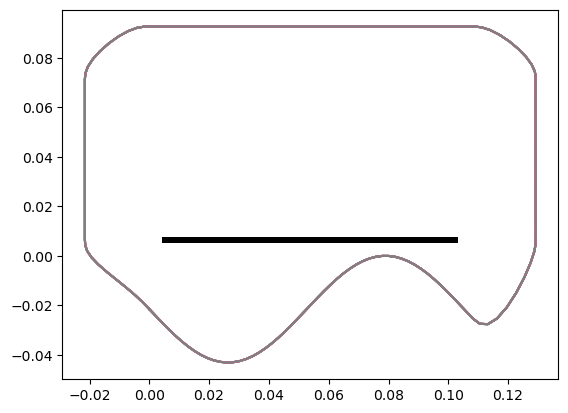

In [ ]:
vecs = []
step = [1, 2, 4, 8, 16, 32, 64, 128]
M_list = [s * 16 for s in step]
for m in M_list:
    problem = StokesTrapezMicProb(data, 0.0, params.width, params.height, 0.0, 8, params.xDim, params.yDim, num_pts=m)
    solver = MicroSolver(problem, tol=1e-10)
    vecs.append(solver.avg_vec)
    problem.plot(plt.gca())
    

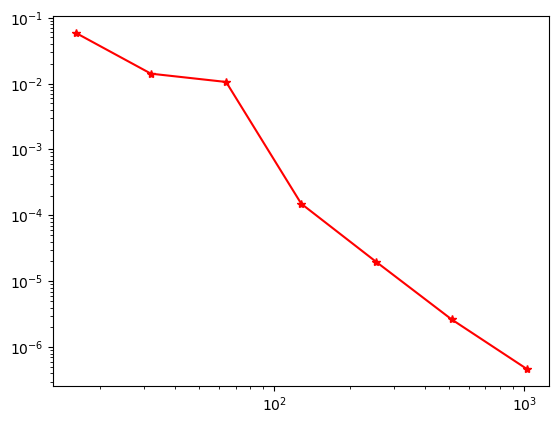

In [ ]:
vec_downsamp = [r[::s] for r,s in zip(vecs, step)]
error = [np.linalg.norm(v - vec_downsamp[-1])/np.linalg.norm(vecs[-1]) for v in vec_downsamp[:-1]]

plt.loglog(M_list[:-1], error, 'r*-')

In [ ]:
# range of data to use : 25 - 59
    
w_list = [3]
n_list = [13]
num_pts = [m]
i_list = list(range(50, 60, 1))

args = [(i, n, w) for i, n, w in product(i_list, n_list, w_list)]

def solve_save(i, n, w):
    data, info = StokesData.load_from_matlab(f"{run_dir}run_{i}.mat")
    data_big_domain = data
    dom = data.dom
    eps = info["eps"]
    print(f"i={i}, (n={n}, w={w}")
    params = HyperParams(nMic=n, xDim=21, yDim=21, width=w*eps, height=w*eps*0.8, tol=1e-8, max_iter=30, num_pts=m)
    setup = Setup(data, params)
    micro_sols, macro_sol, macro_guess = setup.solve()
    setup.save_sol(macro_sol, f"{save_dir}/sol_{i}_{n}_{w}.npy")

In [ ]:

Pool(8).starmap(solve_save, args)

i=50, (n=13, w=3
i=52, (n=13, w=3i=54, (n=13, w=3i=53, (n=13, w=3i=55, (n=13, w=3i=56, (n=13, w=3i=57, (n=13, w=3





i=51, (n=13, w=3
